In [3]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.cluster import KMeans, DBSCAN
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ExKMC.Tree import Tree as ExTree
from ShallowTree.ShallowTree import ShallowTree as ShallowTree_
from intercluster import *
from intercluster.decision_trees import *
from intercluster.decision_sets import *
from intercluster.mining import *
from intercluster.pruning import *
from intercluster.experiments import *

%load_ext autoreload
%autoreload 2

In [5]:
palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

color_dict = {
    0: cmap(1),
    1: cmap(5),
    2: cmap(7),
    3: cmap(6),
    4: cmap(3),
    5: cmap(2),
    6: cmap(4),
    7: cmap(0)
}
color_dict[-1] = 'grey'

# This assumes tex is installed in your system, 
# if not, you may simply remove most of this, aside from font.size 
# (although this will break certain plotting functions)
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

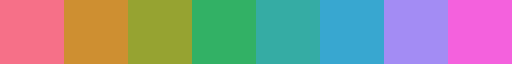

In [6]:
cmap

## Example Setting

The following notebook is intended to work with a simple setting in which the methods and 
algorithms for this library may be tested and experimented with. 

In [36]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 170
np.random.seed(seed)

In [8]:
n = 1000
m = 2
k = 4

cluster_centers = np.array([
    [0,1],
    [0.25, 0.25],
    [0.9, 0.75],
    #[1.55,0.1],
])

data, labels = datasets.make_blobs(
    n_samples=n, centers = cluster_centers, cluster_std=0.125, random_state=seed
)

# Outliers:
data = np.vstack((data, np.array([[0.25,3.5],[0.75,3.5]])))
labels = np.hstack((labels, np.array([3,3])))

Text(0, 0.5, 'y')

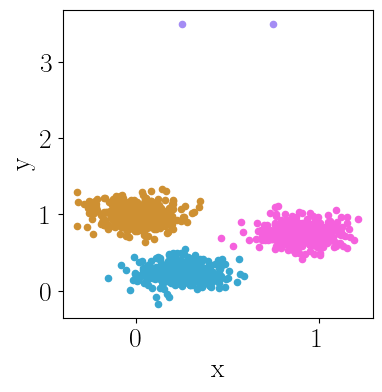

In [9]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labels = np.unique(labels)
for l in uni_labels:
    idx = np.where(labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], alpha = 1, s = 20)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [10]:
# KMeans
kmeans = KMeans(n_clusters=k)
kmeans.fit(data)
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)

In [11]:
kmeans_labels_ = kmeans.labels_
kmeans_labels = labels_format(kmeans_labels_)

Text(0, 0.5, '$x_2$')

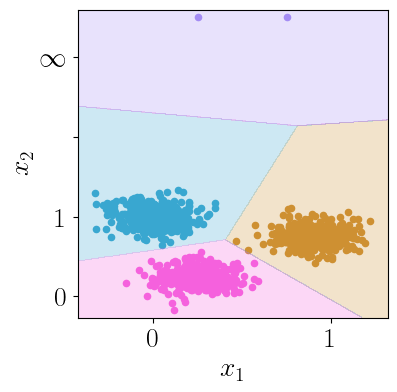

In [12]:
fig,ax = plt.subplots(figsize = (4,4), dpi = 100)
uni_labels = np.unique(kmeans.labels_)
for l in uni_labels:
    idx = np.where(kmeans.labels_ == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)

plot_decision_boundaries(kmeans, data, ax = ax, resolution = 1000, label_array = True, color_dict = color_dict)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#plt.savefig('../figures/examples/outliers_kmeans.png', bbox_inches = 'tight')

In [16]:
n_rules = 4

# Decision Tree
dtree = DecisionTree(
    max_leaf_nodes = n_rules
)
dtree.fit(data, kmeans_labels)
dtree_labels = dtree.predict(data)
dtree_labels_ = flatten_labels(dtree_labels)
dtree_leaf_labels = dtree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
dtree_rule_assignment = labels_to_assignment(dtree_leaf_labels, n_labels = k, ignore = {-1})
dtree_data_to_rule_assignment = dtree.get_data_to_rules_assignment(data)
dtree_data_to_cluster_assignment = dtree_data_to_rule_assignment @ dtree_rule_assignment


# IMM
imm_tree = ExkmcTree(k = k, kmeans = kmeans, max_leaf_nodes = n_rules)
imm_tree.fit(data)
imm_labels = imm_tree.predict(data, leaf_labels = False)
imm_labels_ = flatten_labels(imm_labels)
imm_leaf_labels = imm_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
imm_rule_assignment = labels_to_assignment(imm_leaf_labels, n_labels = k, ignore = {-1})
imm_data_to_rule_assignment = imm_tree.get_data_to_rules_assignment(data)
imm_data_to_cluster_assignment = imm_data_to_rule_assignment @ imm_rule_assignment


# Removal Tree
rem_tree = RemovalTree(num_clusters = k)
rem_tree.fit(data, kmeans_labels)
rem_tree_labels = rem_tree.predict(data, remove_outliers = False)
rem_tree_labels_ = flatten_labels(rem_tree_labels)
rem_tree_leaf_labels = rem_tree.get_leaf_labels()
# This should ignore any rules which are assigned to the outlier class 
rem_tree_rule_assignment = labels_to_assignment(rem_tree_leaf_labels, n_labels = k, ignore = {-1})
rem_tree_data_to_rule_assignment = rem_tree.get_data_to_rules_assignment(data)
rem_tree_data_to_cluster_assignment = rem_tree_data_to_rule_assignment @ rem_tree_rule_assignment


# Decision Set Clustering
rule_miner = PointwiseMiner(samples = 10, prob_dim = 1/2, prob_mistake = 0.0)
dsclust = DSCluster(lambd = 1e6, n_rules = n_rules, rule_miner = rule_miner)
dsclust.fit(data, kmeans_labels)
dsclust_labels = dsclust.predict(data)
dsclust_labels_ = flatten_labels(dsclust_labels)
# This should ignore any rules which are assigned to the outlier class, but note that we already preventing outlier rules 
# in the DSCluster algorithm. This is here mostly for consistency.
dsclust_rule_assignment = labels_to_assignment(dsclust.decision_set_labels, n_labels = k, ignore = {-1})
dsclust_data_to_rule_assignment = dsclust.get_data_to_rules_assignment(data)
dsclust_data_to_cluster_assignment = dsclust_data_to_rule_assignment @ dsclust_rule_assignment 

True
-0.3252803373759871
-0.3209555320837903
-0.3203930877796063
-0.28369028637284066
-0.2669618722538688
-0.2638355715096016
-0.25826608073769874
-0.25805378585399713
-0.25334536294761933
-0.24697974825122285
-0.23875688236403084
-0.23722584053447487
-0.2333138288478576
-0.23097859970784343
-0.22748338009742133
-0.22505970301336506
-0.22417486615783586
-0.22241909073673735
-0.2217925099670967
-0.22020007443858436
-0.2158851410561866
-0.21129761943307424
-0.1939971954508453
-0.19364862218901507
-0.19132036917860362
-0.1885272999438445
-0.18546987752100996
-0.18271865860653233
-0.17731468912860474
-0.17645907124144664
-0.17609934777844147
-0.175757749504169
-0.17400331572334418
-0.16960577547247394
-0.1692711552284292
-0.1672813659997765
-0.1653847694098659
-0.1584640057117259
-0.15807761115849955
-0.15674859570614422
-0.15174710389841256
-0.1511327781943288
-0.1503957361618852
-0.14296489071418061
-0.14100601367465065
-0.138424061587875
-0.13537954122383553
-0.13502822718248148
-0.1315

In [11]:
n_mine = 20

lambdas = [
    1/n_mine,
    1/(2 * data.shape[1] * n_mine),
    1/(len(data) * (n_mine**2)),
    1/(len(data) * (n_mine**2)),
    k,
    1/(data.shape[0] * n_mine),
    1/(data.shape[0])
]


rule_miner = AssociationRuleMiner(max_rules = n_mine)
ids_set = IdsSet(lambdas = lambdas, rule_miner = rule_miner)
ids_set.fit(data, kmeans_labels)
ids_set_labels = ids_set.predict(data)
#ids_set_labels_ = flatten_labels(ids_set_labels)
ids_set_labels_ = np.array([min(labs) for labs in ids_set_labels])
ids_set_rule_assignment = labels_to_assignment(ids_set.decision_set_labels, n_labels = k, ignore = {-1})
ids_set_data_to_rule_assignment = ids_set.get_data_to_rules_assignment(data)
ids_set_data_to_cluster_assignment = ids_set_data_to_rule_assignment @ ids_set_rule_assignment

Lambdas found: [0.05, 0.0125, 2.4950099800399203e-06, 2.4950099800399203e-06, 4, 4.99001996007984e-05, 0.000998003992015968]


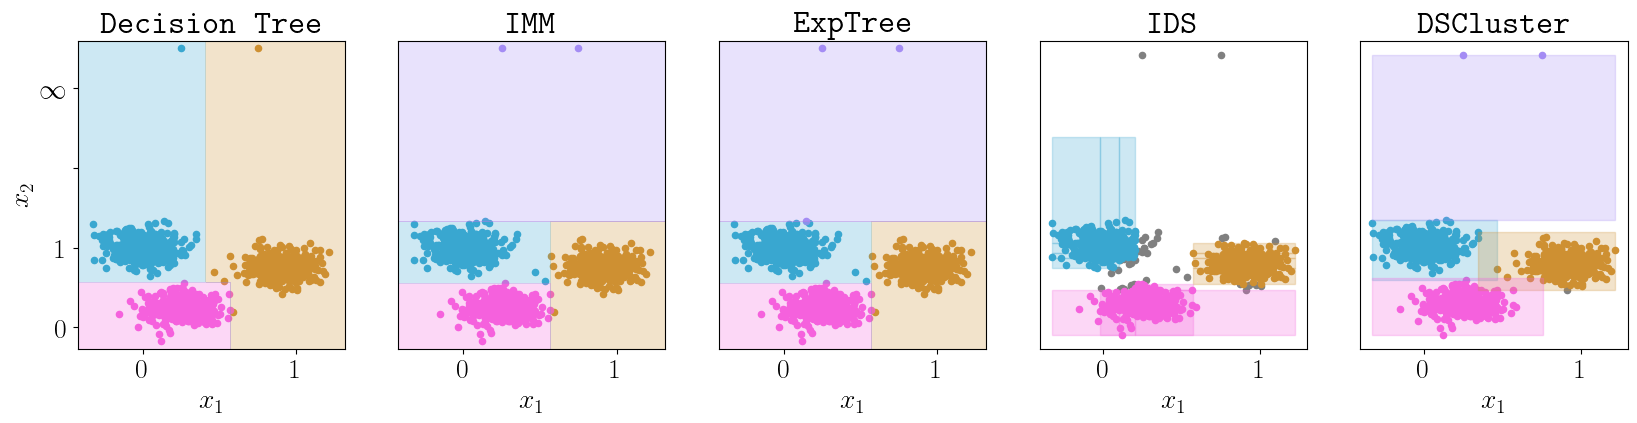

In [ ]:
fig,axs = plt.subplots(nrows = 1, ncols = 5, figsize = (20,4), dpi = 100)

# Decision Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(dtree_labels_ == l)[0]
    axs[0].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(dtree, data, color_dict, ax = axs[0], resolution = 1000, label_array = False)
axs[0].set_xlabel(r'$x_1$')
axs[0].set_title(r"\texttt{Decision Tree}")

# IMM
uniqie_labs = np.unique(imm_labels_)
for l in uniqie_labs:
    idx = np.where(imm_labels_ == l)[0]
    axs[1].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(imm_tree, data, color_dict, ax = axs[1], resolution = 1000, label_array = False)
axs[1].set_xlabel(r'$x_1$')
axs[1].set_title(r"\texttt{IMM}")

# Removal Tree
uniqie_labs = np.unique(rem_tree_labels_)
for l in uniqie_labs:
    idx = np.where(rem_tree_labels_ == l)[0]
    axs[2].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(rem_tree, data, color_dict, ax = axs[2], resolution = 1000, label_array = False)
axs[2].set_xlabel(r'$x_1$')
axs[2].set_title(r"\texttt{ExpTree}")

# IDS
uniqie_labs = np.unique(ids_set_labels_)
for l in uniqie_labs:
    idx = np.where(ids_set_labels_ == l)[0]
    axs[3].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(ids_set, data, color_dict, axs[3])
axs[3].set_xlabel(r'$x_1$')
axs[3].set_title(r"\texttt{IDS}")

# Decision Set Clustering
uniqie_labs = np.unique(dsclust_labels_)
for l in uniqie_labs:
    idx = np.where(dsclust_labels_ == l)[0]
    axs[4].scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(dsclust, data, color_dict, axs[4])
axs[4].set_xlabel(r'$x_1$')
axs[4].set_title(r"\texttt{DSCluster}")


y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
axs[0].set_yticks(y_tick_locations)
axs[0].set_yticklabels(y_tick_labels)
axs[0].set_ylabel(r'$x_2$')

axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)
axs[3].yaxis.set_visible(False)
axs[4].yaxis.set_visible(False)

#plt.savefig("../figures/examples/counter_example.png", bbox_inches = 'tight', dpi = 300)

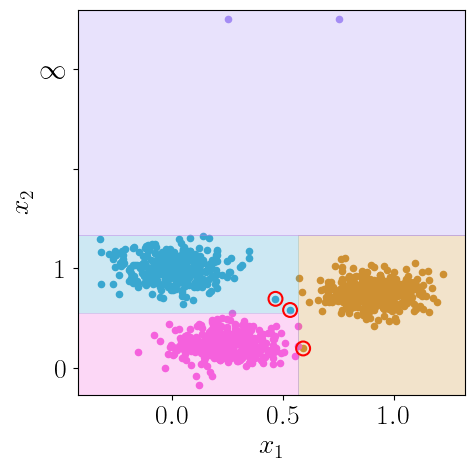

In [13]:
algname = "removal_tree"
alg = rem_tree
alg_labels = rem_tree_labels_
title = r"\texttt{ExpTree}"

fig,ax = plt.subplots(figsize = (5,5), dpi = 100)

uni_labs = np.unique(alg_labels)
for l in uni_labs:
    idx = np.where(alg_labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_decision_boundaries(alg, data, color_dict, ax = ax, resolution = 1000, label_array = False)

# Mark misclassified points
misclassified = np.where(alg_labels != kmeans_labels_)[0]
ax.scatter(data[misclassified,0], data[misclassified,1], facecolors = 'none', edgecolors = 'red', s = 100, linewidths = 1.5)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title(title)
plt.savefig("../figures/examples/outliers/" + algname + ".png", bbox_inches = 'tight', dpi = 300)


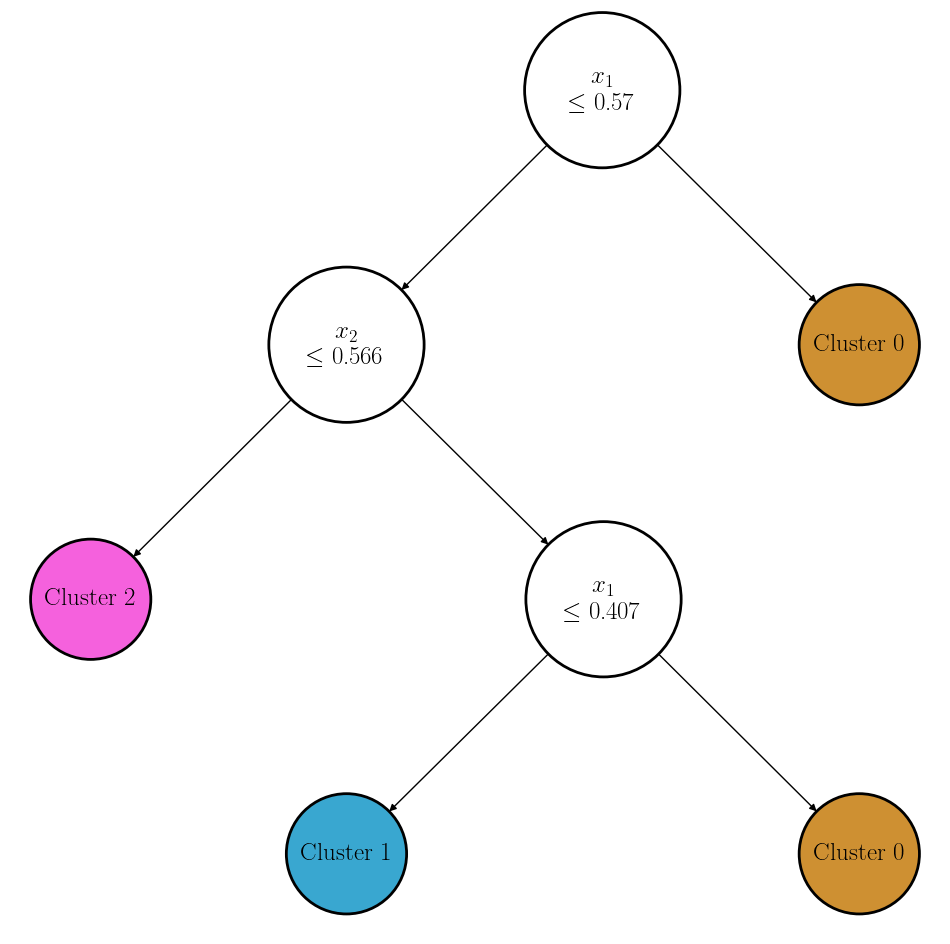

In [44]:
draw_tree(
    root = alg.root,
    color_dict = color_dict,
    feature_labels = [r'$x_1$', r'$x_2$'],
    output_file = "../figures/examples/outliers/" + algname + "_rules.png"
)

Text(0, 0.5, '$x_2$')

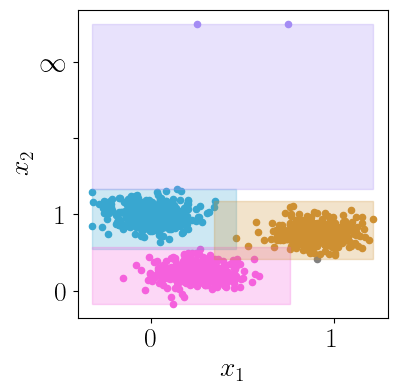

In [17]:
algname = "dsclust"
alg = dsclust
alg_labels = dsclust_labels_
#title = r"\texttt{IDS}"

fig,ax = plt.subplots(figsize = (4,4), dpi = 100)

uni_labs = np.unique(alg_labels)
for l in uni_labs:
    idx = np.where(alg_labels == l)[0]
    ax.scatter(data[idx,0], data[idx,1], color = color_dict[l], s = 20)
plot_rule_boxes(alg, data, color_dict, ax)

y_tick_locations = [0, 1, 2, 3]
y_tick_labels = ['0', '1', '', r'$\infty$']
ax.set_yticks(y_tick_locations)
ax.set_yticklabels(y_tick_labels)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title(title)
#plt.savefig("../figures/examples/outliers/" + algname + ".png", bbox_inches = 'tight', dpi = 300)

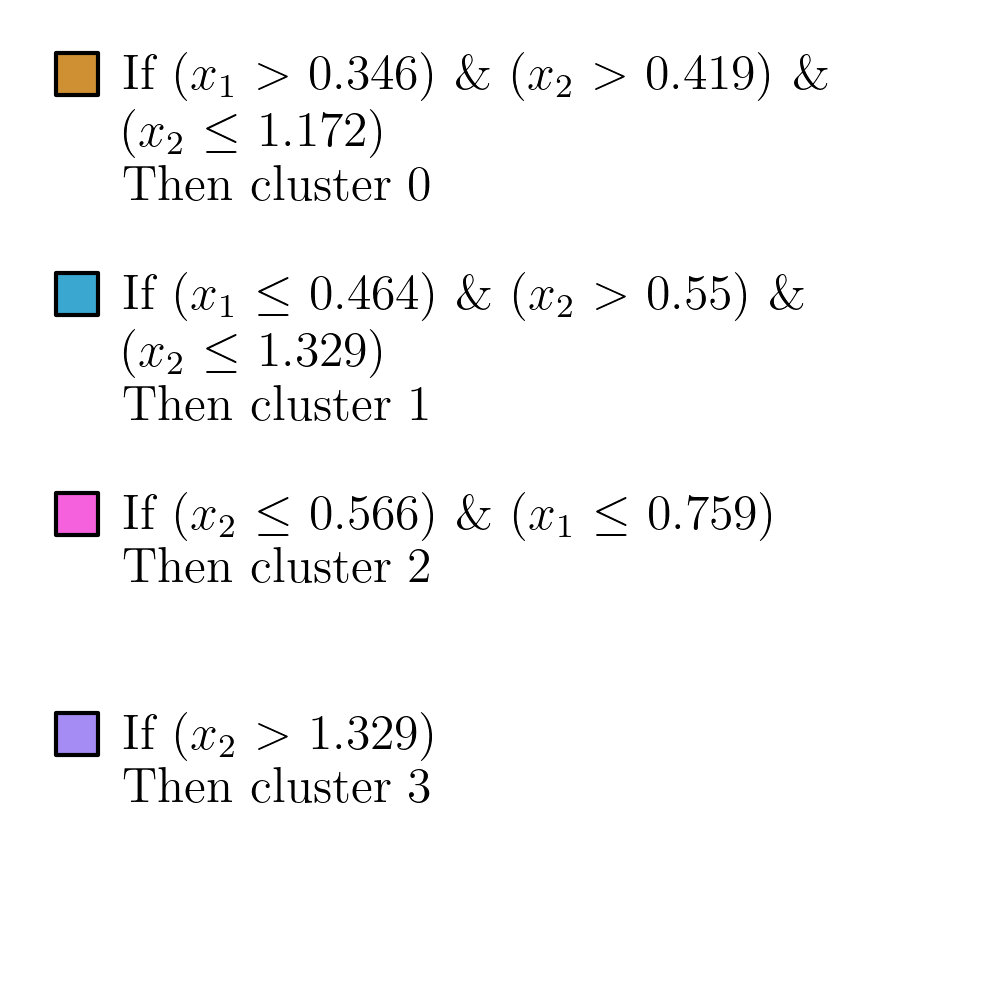

In [51]:
plot_decision_set(
    decision_set = alg.decision_set,
    rule_labels = alg.decision_set_labels,
    color_dict = color_dict,
    feature_labels = [r'$x_1$', r'$x_2$'],
    size_factor = 1,
    filename = "../figures/examples/outliers/" + algname + "_rules.png",
)

### DBSCAN Example